## Loading the data

In [2]:
import numpy as np
import scanpy as sc

import os 

sc.set_figure_params(dpi=100, frameon=False)
sc.logging.print_header()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 leidenalg==0.8.3


In [3]:
os.getcwd()

'/home/mo/projects/test_AdvAE/Norman_results'

In [4]:
adata = sc.read('../datasets/Norman2019_prep_new.h5ad')

## Loading the model

In [5]:
os.chdir("../")

IMPORTANT. Currenlty because of the standartized evaluation procedure, we need to provide adata.obs['control'] (0 if not control, 1 for cells to use as control). And we also need to provide de_genes in .uns['rank_genes_groups']. This genes corresond to the groups of drugs in adata.obs['drug_dose_name']. adata.obs['drug_dose_name'] is a neccessary field to standartized evaluation even for the datasets that don't have doses.

In [6]:
import torch
from compert.train import prepare_compert

state, args, metrics = torch.load('./pretrained_models/Norman2019_prep_new_deg_collect/relu/sweep_Norman2019_prep_new_relu_split1_model_seed=16_epoch=80.pt', map_location=torch.device('cpu'))
args['dataset_path'] = './datasets/Norman2019_prep_new.h5ad'
args['save_dir'] = '/ckpts'
# load the dataset and model pre-trained weights
model, datasets = prepare_compert(args, state_dict=state)

In [6]:
args

{'dataset_path': './datasets/Norman2019_prep_new.h5ad',
 'perturbation_key': 'condition',
 'dose_key': 'dose_val',
 'cell_type_key': 'cell_type',
 'split_key': 'split1',
 'loss_ae': 'gauss',
 'doser_type': 'linear',
 'decoder_activation': 'ReLU',
 'seed': 16,
 'hparams': '',
 'max_epochs': 2000,
 'max_minutes': 300,
 'patience': 20,
 'checkpoint_freq': 20,
 'save_dir': '/ckpts',
 'sweep_seeds': 200}

In [7]:
%%time
from compert.data import load_dataset_splits

datasets, full_dataset = load_dataset_splits(
    dataset_path=args['dataset_path'],
    perturbation_key=args['perturbation_key'],
    dose_key=args['dose_key'],
    cell_type_key=args['cell_type_key'],
    split_key = args["split_key"],
    return_dataset=True)  

CPU times: user 38.9 s, sys: 2.06 s, total: 40.9 s
Wall time: 38 s


In [8]:
from compert.plotting import CompertVisuals
from compert.api import ComPertAPI

In [10]:
compert_api = ComPertAPI(datasets, model)

####  Predicition of CNN1 + CBL

In [11]:
adata.var_names = adata.var.gene_symbols

In [12]:
import seaborn as sns

In [13]:
np.random.seed(0)
sns.set_style("whitegrid")

In [14]:
adata_ood = adata[adata.obs["split1"] == "ood"]

In [15]:
adata_ood.obs["condition"].value_counts()

DUSP9+ETS2     787
ETS2+MAPK1     459
CBL+CNN1       348
DUSP9+MAPK1    290
Name: condition, dtype: int64

In [22]:
ood = ["CBL+CNN1"]

In [23]:
condition_key = "condition"

In [24]:
torch.random.seed = 300

In [25]:
import pandas as pd

In [26]:
adata_ood = adata[adata.obs[condition_key].isin(ood)]
adata_ood.X = adata_ood.X.A
adata_source = adata[adata.obs[condition_key] == "ctrl"]                              
adata_source.X = np.array(adata_source.X.A)
for comb in ood:
    print(comb)
    adata_target = adata[adata.obs[condition_key] == comb]
    indice = np.random.choice(np.arange(len(adata_source)), size=len(adata_target))
    adata_source_2 = adata_source[indice,:]
    adata_target.X = np.array(adata_target.X.todense())
    genes_control = full_dataset.genes[full_dataset.indices['control']]
    perm = torch.randperm(genes_control.size(0),)
    idx = perm[:500]
    ss_ctrl = genes_control[idx]
    df = pd.DataFrame({args['perturbation_key']: ood, 
                       args['dose_key']: ['1+1'], 
                       args['cell_type_key']: ['A549']})
    predicted_data = compert_api.predict(ss_ctrl, df, return_anndata=True)
    adata_pred = sc.AnnData(predicted_data)
    adata_pred.var_names = adata.var_names
    adata_pred.obs[condition_key] = [f"pred_{comb}"] * len(adata_pred)
    adata_pred.var_names = adata_source.var_names.tolist()
    adata_ood = adata_ood.concatenate(adata_pred)

CBL+CNN1


/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [27]:
condition_key = "condition"
single = ["CBL+ctrl", "ctrl+CNN1","DUSP9+ctrl","ctrl+CEBPA", "KLF1+ctrl","ctrl+ETS2","ctrl+MAPK1","PTPN12+ctrl","ctrl+SNAI1","ctrl"]

In [28]:
single_ood = adata[adata.obs[condition_key].isin(single)]

In [29]:
all_adata = single_ood.concatenate(adata_ood)

In [30]:
ctrl = all_adata[all_adata.obs[condition_key] == "ctrl"]

In [31]:
sc.pp.subsample(ctrl,n_obs=1000)

In [32]:
other = all_adata[all_adata.obs[condition_key] != "ctrl"]
all_adata = other.concatenate(ctrl)

In [33]:
to_select = ["CBL+ctrl",'CBL+CNN1', "ctrl+CNN1","pred_CBL+CNN1","ctrl"] 

In [34]:
story_1 = all_adata[all_adata.obs[condition_key].isin(to_select)]

In [35]:
ctrl = story_1[story_1.obs[condition_key] == "ctrl"]
ctrl.obs["order"] = np.linspace(0,0.1, num=len(ctrl))
CBL_ctrl = story_1[story_1.obs[condition_key] == "CBL+ctrl"]
CBL_ctrl.obs["order"] = np.linspace(.11,0.2, num=len(CBL_ctrl))
ctrl_CNN1 = story_1[story_1.obs[condition_key] == "ctrl+CNN1"]
ctrl_CNN1.obs["order"] = np.linspace(.21,0.4, num=len(ctrl_CNN1))
CBL_CNN1 = story_1[story_1.obs[condition_key] == "CBL+CNN1"]
CBL_CNN1.obs["order"] = np.linspace(0.41,0.5, num=len(CBL_CNN1))
pred_CBL_CNN1 = story_1[story_1.obs[condition_key] == "pred_CBL+CNN1"]
pred_CBL_CNN1.obs["order"] = np.linspace(.51,0.6, num=len(pred_CBL_CNN1))

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [36]:
story_1 = sc.AnnData.concatenate(ctrl,CBL_ctrl,ctrl_CNN1,CBL_CNN1,pred_CBL_CNN1)

In [37]:
genes_story1 = ["LC25A37", "HBZ" ,"PRELID1" ,"MIF" ,"TMSB4X" ,"PRSS57", "GMFG" ,"TEX30", "PKM" ,"CD99", "XG", "ZFP36L1",
 "REEP6 EEF1A1" ,"GSTP1", "GYPA", "NARF" , "HBA2" ,"ALAS2" ,"HBA1", "SMIM1", "GYPB", "TESC", "COL18A1", "CHI3L2", "APOE", "APOC1", "HBG2", "HBG1", "BLVRP"]

In [40]:
for g in genes_story1:
    if not g in story_1.var_names:
        genes_story1.remove(g)

In [41]:
import scvelo as scl

In [42]:
story_1.obs[condition_key].value_counts()

ctrl             1000
CBL+ctrl          663
pred_CBL+CNN1     500
ctrl+CNN1         480
CBL+CNN1          348
Name: condition, dtype: int64

In [43]:
story_1_umap = story_1[story_1.obs[condition_key] != "CBL+CNN1"]
story_1_gt = story_1[story_1.obs[condition_key] != "pred_CBL+CNN1"]

In [44]:
sc.pp.neighbors(story_1_umap, n_neighbors=8)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [45]:
sc.tl.umap(story_1_umap)

... storing 'cov_drug_dose_name' as categorical
... storing 'dose_val' as categorical
... storing 'condition' as categorical
... storing 'guide_identity' as categorical
... storing 'drug_dose_name' as categorical
... storing 'cell_type' as categorical
... storing 'split' as categorical
... storing 'split1' as categorical
... storing 'split2' as categorical
... storing 'split3' as categorical
... storing 'split4' as categorical
... storing 'split5' as categorical
... storing 'split6' as categorical
... storing 'split7' as categorical
... storing 'split8' as categorical
... storing 'split9' as categorical
... storing 'split10' as categorical
... storing 'split11' as categorical
... storing 'split12' as categorical
... storing 'split13' as categorical
... storing 'split14' as categorical
... storing 'split15' as categorical
... storing 'split16' as categorical
... storing 'split17' as categorical
... storing 'split18' as categorical
... storing 'split19' as categorical
... storing 'split2

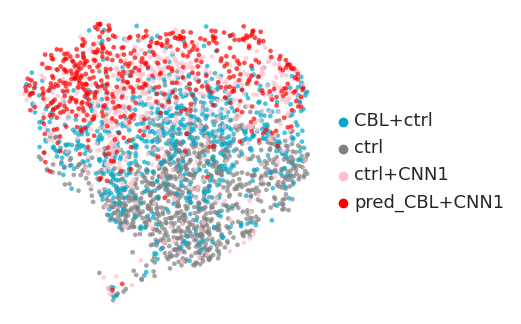

In [46]:
sc.pl.umap(story_1_umap,color=condition_key,
              palette=["#00a8cc","gray","pink","red"],
              alpha=0.7,title="",frameon=False)

In [62]:
story_1_umap.obs.condition.value_counts()

ctrl             1000
CBL+ctrl          663
pred_CBL+CNN1     500
ctrl+CNN1         480
Name: condition, dtype: int64

In [52]:
sns.set(font_scale=1)

saving figure to file ./figures/scvelo_heatmap_CBN1+CNN1_pred_relu_test.png


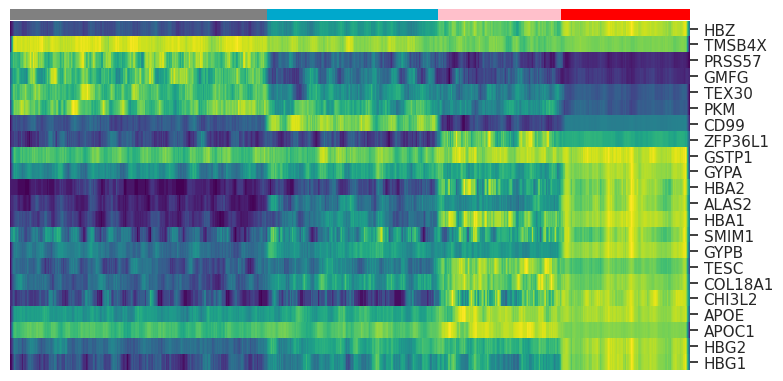

In [53]:
scl.pl.heatmap(story_1_umap, var_names=genes_story1, sortby="order",
               col_color=condition_key,colorbar=True,sort=False,save="CBN1+CNN1_pred_relu_test.png", yticklabels=True)

In [55]:
#real cell

In [56]:
sc.tl.pca(story_1_gt)

In [57]:
sc.pp.neighbors(story_1_gt)

In [58]:
sc.tl.umap(story_1_gt)

... storing 'cov_drug_dose_name' as categorical
... storing 'dose_val' as categorical
... storing 'condition' as categorical
... storing 'guide_identity' as categorical
... storing 'drug_dose_name' as categorical
... storing 'cell_type' as categorical
... storing 'split' as categorical
... storing 'split1' as categorical
... storing 'split2' as categorical
... storing 'split3' as categorical
... storing 'split4' as categorical
... storing 'split5' as categorical
... storing 'split6' as categorical
... storing 'split7' as categorical
... storing 'split8' as categorical
... storing 'split9' as categorical
... storing 'split10' as categorical
... storing 'split11' as categorical
... storing 'split12' as categorical
... storing 'split13' as categorical
... storing 'split14' as categorical
... storing 'split15' as categorical
... storing 'split16' as categorical
... storing 'split17' as categorical
... storing 'split18' as categorical
... storing 'split19' as categorical
... storing 'split2

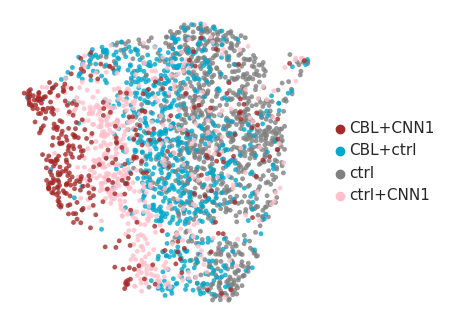

In [59]:
sc.pl.umap(story_1_gt,color=condition_key,
              palette=["brown","#00a8cc","gray","pink"],
              alpha=0.8,title="",frameon=False,save="real_CBL+CNN1_test.pdf")

In [60]:
sns.set(font_scale=1)

In [63]:
story_1_gt.obs.condition.value_counts()

ctrl         1000
CBL+ctrl      663
ctrl+CNN1     480
CBL+CNN1      348
Name: condition, dtype: int64

saving figure to file ./figures/scvelo_heatmap_real_CBL+CNN1_hm.png


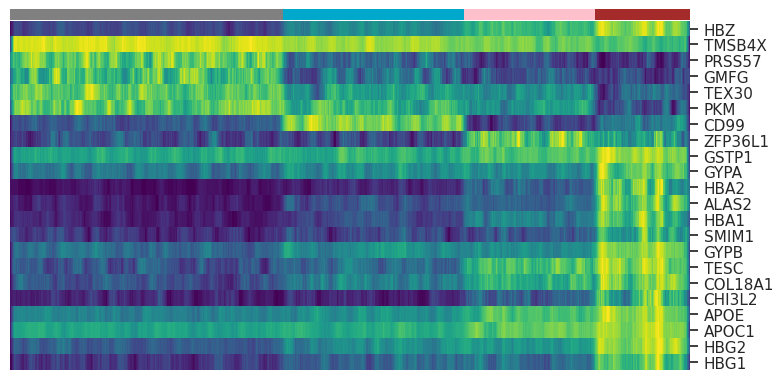

In [64]:
scl.pl.heatmap(story_1_gt, var_names=genes_story1, sortby="order",
               col_color=condition_key,show=True,sort=False,save="real_CBL+CNN1_hm.png", yticklabels=True)

In [65]:
sns.set_style("white")

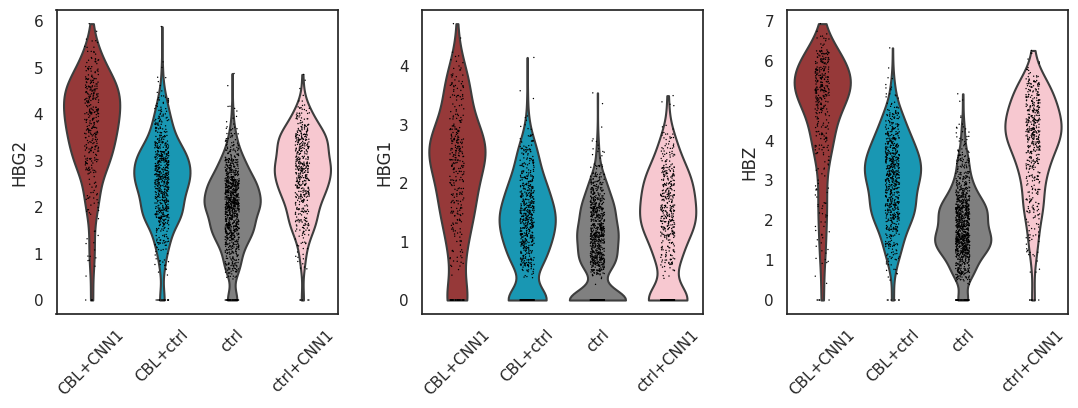

In [66]:
sc.pl.violin(story_1_gt,keys=["HBG2","HBG1",
                              "HBZ"],groupby=condition_key,rotation=45,save="hbg.png")